In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.outliers import Winsorizer
from sklearn.ensemble import IsolationForest
import eda_helper_functions
from functools import lru_cache
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn
import warnings

In [72]:
geolocator = Nominatim(user_agent="MyApp")
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

In [73]:
## Reading train data

train = pd.read_csv(r"C:\Users\yashg\OneDrive\Desktop\flight-sagemaker\data\train.csv")

In [74]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,No info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,No info,10975
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,No info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,No info,5678


In [75]:
train.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [76]:
train.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

In [77]:
## Fizing datatypes

for col in ['date_of_journey', "dep_time", "arrival_time"]:
    train[col] = pd.to_datetime(train[col], dayfirst=True, format="mixed")

In [78]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

### High-level Summary of Data

In [79]:
train.describe(include=[int,float])

,duration,total_stops,price
count,6694.000000,6694.000000,6694.000000
mean,637.633702,0.812668,9092.553331
std,504.395941,0.658143,4670.489223
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5277.000000
50%,515.000000,1.000000,8372.000000
75%,925.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [80]:
train.assign(total_stops=train["total_stops"].astype(object)).describe(include="O")

,airline,source,destination,total_stops,additional_info
count,6694,6694,6694,6694,6694
unique,9,5,5,4,9
top,Jet Airways,Delhi,Cochin,1,No info
freq,2387,2781,2781,3638,5225


## 1. Price column fixed

<Axes: xlabel='price', ylabel='Count'>

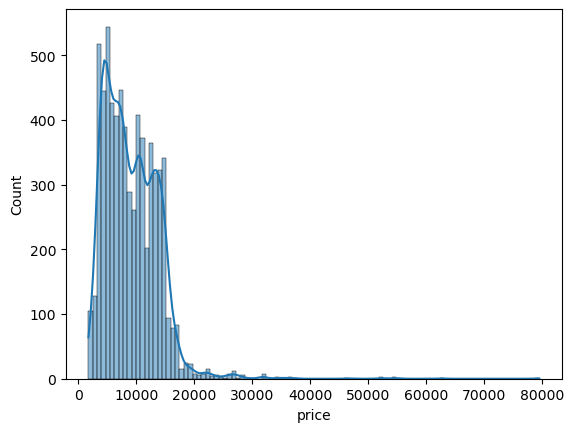

In [81]:
sns.histplot(train["price"], kde=True)

In [82]:
win = Winsorizer(capping_method="iqr", fold=1.5)
train["price"] = win.fit_transform(pd.DataFrame(train["price"], columns = ["price"]))

<Axes: ylabel='Count'>

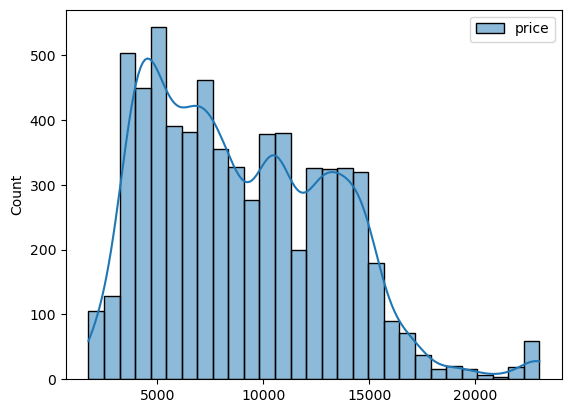

In [83]:
sns.histplot(price, kde=True)

## 2. Airline column

In [210]:
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
airline_count_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.05, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("count_encoder", CountFrequencyEncoder()),
                                	# ("scaler", PowerTransformer())
    
])


count_airline = airline_count_transformer.fit_transform(train.loc[:, ["airline"]])


In [211]:
count_airline["price"] = price

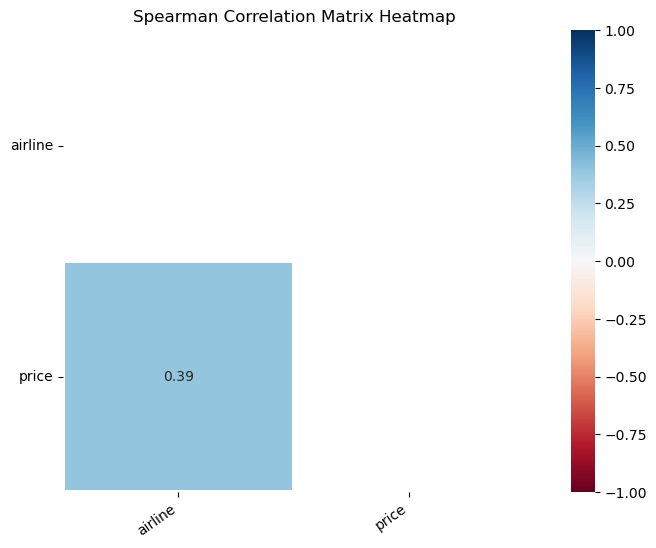

In [212]:
eda_helper_functions.correlation_heatmap(count_airline)

In [216]:
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
airline_mean_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.05, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("mean_encoder", MeanEncoder()),
                                	("scaler", PowerTransformer())
    
])


mean_airline = airline_mean_transformer.fit_transform(train.loc[:, ["airline"]], train.price)


In [217]:
mean_airline["price"] = price

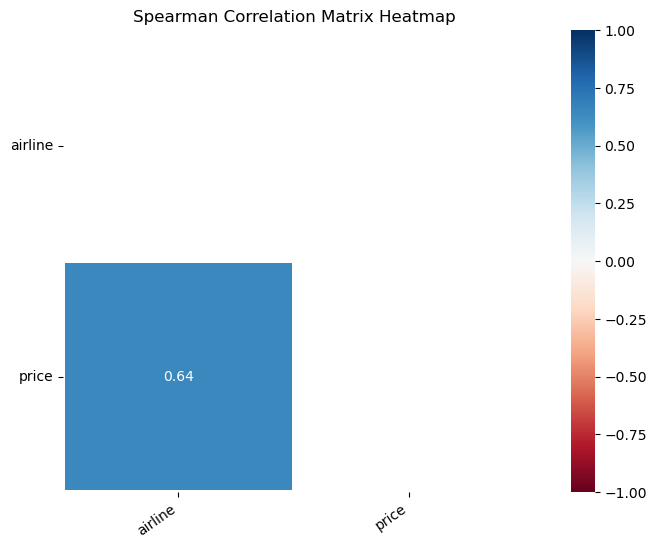

In [218]:
eda_helper_functions.correlation_heatmap(mean_airline)

In [160]:
airline_onehot_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    
])


onehot_airline = airline_onehot_transformer.fit_transform(train.loc[:, ["airline"]])

In [162]:


# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(onehot_airline)

# Step 2: Apply PCA to reduce dimensions to 1 component
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Step 3: Add the resulting PCA column to the DataFrame
onehot_airline[['pca_component_1', 'pca_component_2']] = pca_result


In [163]:
onehot_airline["price"] = train["price"]

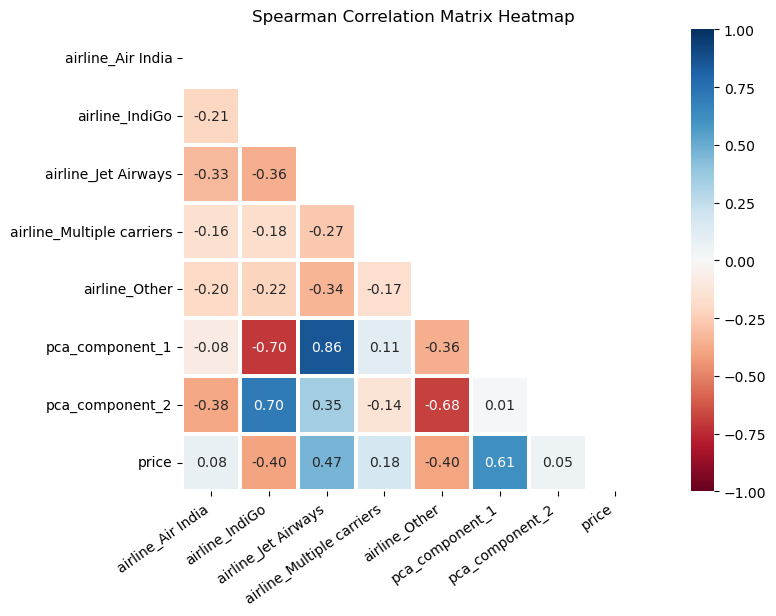

In [164]:
eda_helper_functions.correlation_heatmap(onehot_airline)

In [168]:
## Correaltion b/w meanencoder and pca1
mean_airline["airline"].corr(onehot_airline["pca_component_1"])

0.8033625664515348

## Analysis

- We can see Correaltion b/w mean_encoder and pca1 is high, so we will only take 1
- MeanEncoder is giving more association w.r.t price.

### 2. date_of_journey 

In [78]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

In [110]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year","weekend"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer_df = doj_transformer.fit_transform(train.loc[:, ["date_of_journey"]])

In [108]:
doj_transformer_df["price"] = train["price"]

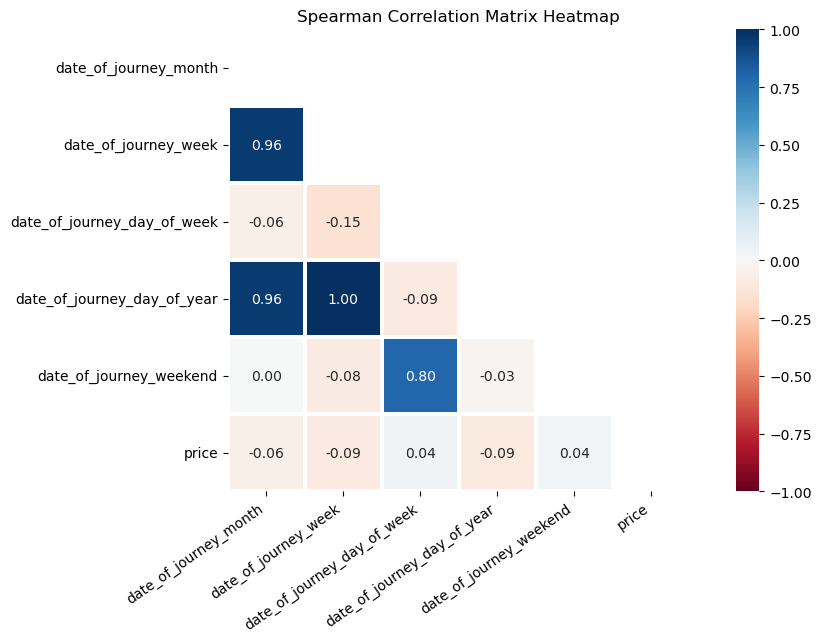

In [109]:
eda_helper_functions.correlation_heatmap(doj_transformer_df)

In [101]:
from sklearn.decomposition import PCA

In [111]:


# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(doj_transformer_df)

# Step 2: Apply PCA to reduce dimensions to 1 component
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_data)

# Step 3: Add the resulting PCA column to the DataFrame
doj_transformer_df['pca_component_1'] = pca_result


In [112]:
doj_transformer_df["price"] = train["price"]

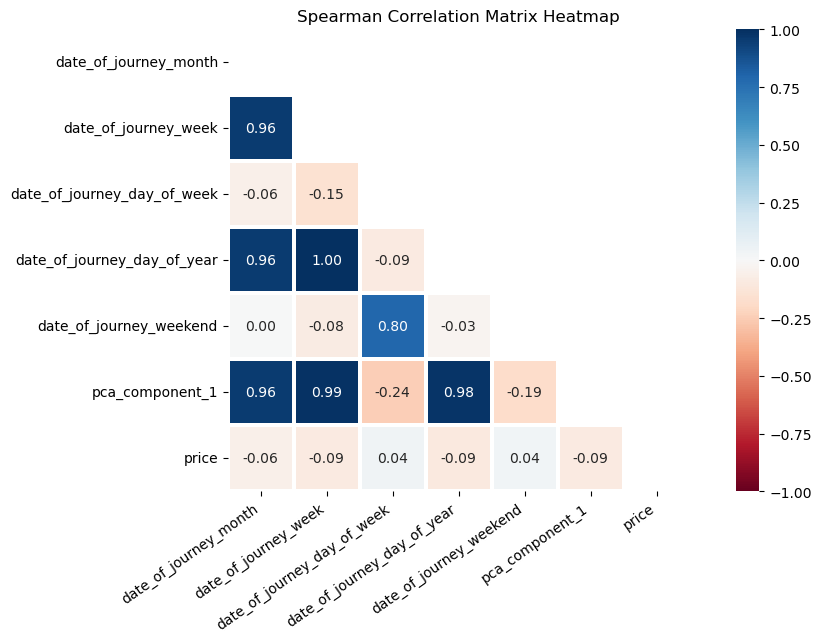

In [113]:
eda_helper_functions.correlation_heatmap(doj_transformer_df)

### Analysis of Date of journey

- There is not single column of date which is correalted, every column corraeltion is near 0.
- Evene PCA is not able to generate information and correaltion to it is near 0.

## 3. Source and destination column analysis

- In our previous EDA file, we can see that there is a high correaltion b/w source and destination.

In [128]:
sd_subset = train[["source","destination"]]
sd_subset[["source", "destination"]] = sd_subset[["source", "destination"]].apply(lambda col: col.str.lower())

In [129]:
sd_subset["source_destination"] = (sd_subset["source"].astype(str) + "_" + sd_subset["destination"])
sd_subset

,source,destination,source_destination
0,delhi,cochin,delhi_cochin
1,kolkata,banglore,kolkata_banglore
2,delhi,cochin,delhi_cochin
3,mumbai,hyderabad,mumbai_hyderabad
4,mumbai,hyderabad,mumbai_hyderabad
...,...,...,...
6689,kolkata,banglore,kolkata_banglore
6690,delhi,cochin,delhi_cochin
6691,delhi,cochin,delhi_cochin
6692,delhi,cochin,delhi_cochin


In [141]:
sd_subset["source_destination"].value_counts(normalize=True)

source_destination
delhi_cochin        0.415447
kolkata_banglore    0.280550
banglore_delhi      0.202420
mumbai_hyderabad    0.066627
chennai_kolkata     0.034957
Name: proportion, dtype: float64

In [146]:
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
sd_count_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("count_encoder", CountFrequencyEncoder()),
                                	("scaler", PowerTransformer())
    
])


count_sd = sd_count_transformer.fit_transform(sd_subset.loc[:, ["source_destination"]])


In [147]:
count_sd["price"] = train["price"]

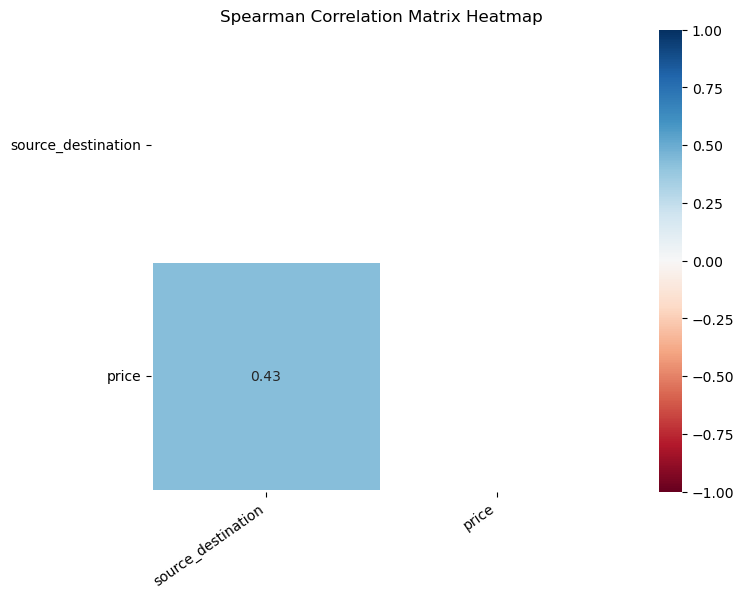

In [148]:
eda_helper_functions.correlation_heatmap(count_sd)

In [153]:
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
sd_mean_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("mean_encoder", MeanEncoder()),
                                	("scaler", PowerTransformer())
    
])


mean_sd = sd_mean_transformer.fit_transform(sd_subset.loc[:, ["source_destination"]], train.price)


In [154]:
mean_sd["price"] = train["price"]

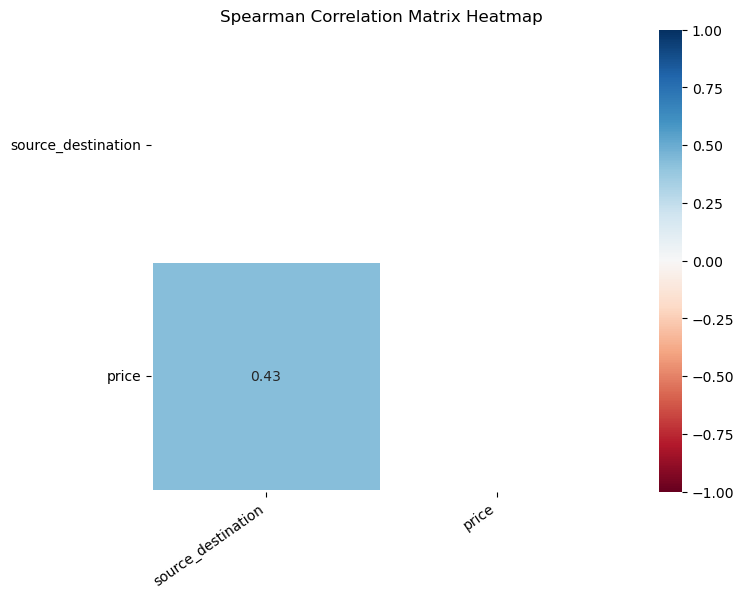

In [155]:
eda_helper_functions.correlation_heatmap(mean_sd)

In [173]:
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
sd_onehot_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
                                	("scaler", PowerTransformer())
    
])


onehot_sd = sd_onehot_transformer.fit_transform(sd_subset.loc[:, ["source_destination"]], train.price)


In [174]:


# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(onehot_sd)

# Step 2: Apply PCA to reduce dimensions to 1 component
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_data)

# Step 3: Add the resulting PCA column to the DataFrame
onehot_sd['pca_component_1'] = pca_result


In [175]:
onehot_sd["price"] = train["price"]

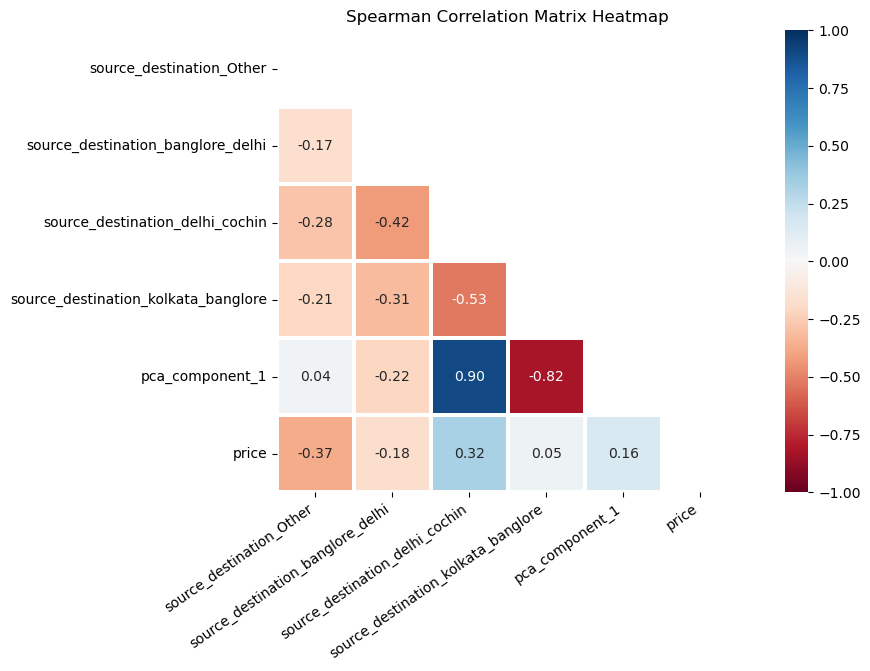

In [176]:
eda_helper_functions.correlation_heatmap(onehot_sd)

## Analysis

- Best correaltion we are getting is from Mean and count, lets take count becoz, in airline we took mean.
- Also add that distance b/w column we created

## 4 dep_time and arrival_time

### 4.1 Dep_time

## 5 Duration

In [179]:
duration = train[["duration","price"]]

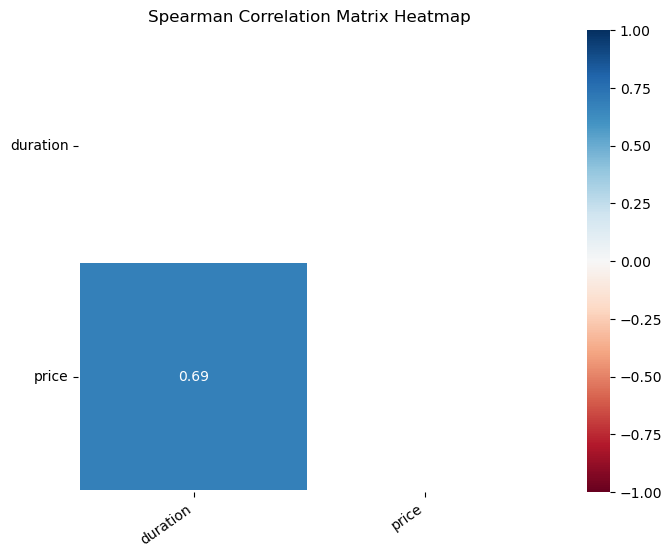

In [180]:
eda_helper_functions.correlation_heatmap(duration)

## 6. additional_info

- In previous EDA, additonal info is not giving any new info or correlation with targe variable

## 7. Distance b/w source and destination

In [185]:
# Use caching to store previously computed distances
@lru_cache(maxsize=None)
def get_lat_long(city):
    """Get latitude and longitude for a given city."""
    location = geolocator.geocode(f"{city}, India")
    if location:
        return location.latitude, location.longitude
    else:
        return None

def distance_between_cities(source, destination):
    """Calculate the distance between two cities using geopy."""
    lat_long_city1 = get_lat_long(source)
    lat_long_city2 = get_lat_long(destination)
    
    if lat_long_city1 and lat_long_city2:
        # Calculate distance between the two cities
        distance = GD(lat_long_city1, lat_long_city2).km
        return distance
    else:
        return None  # If one of the locations is not found

def return_distance_df(train):
    """Apply distance calculation to each row in the DataFrame."""
    distance = train.apply(lambda row: distance_between_cities(row['source'], row['destination']), axis=1)
    return pd.DataFrame(distance, columns=["distance_between_cities"])




In [197]:
distance_bw_source_destination = train.apply(lambda row: distance_between_cities(row['source'], row['destination']), axis=1)

In [200]:
distance_bw_source_destination_df = pd.DataFrame(distance_bw_source_destination, columns = ["distance_bw_source_destination"])


In [202]:
distance_bw_source_destination_df["price"] = train["price"]

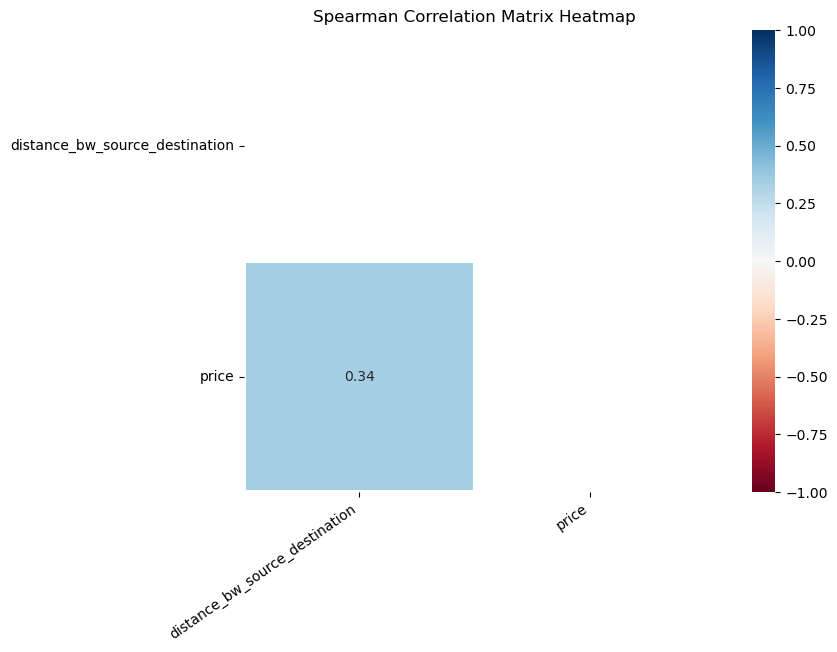

In [203]:
eda_helper_functions.correlation_heatmap(distance_bw_source_destination_df)

- Add this column in our model building

## Total_Stops

In [205]:
train.total_stops

0       1
1       1
2       2
3       0
4       0
       ..
6689    1
6690    1
6691    2
6692    1
6693    1
Name: total_stops, Length: 6694, dtype: int64

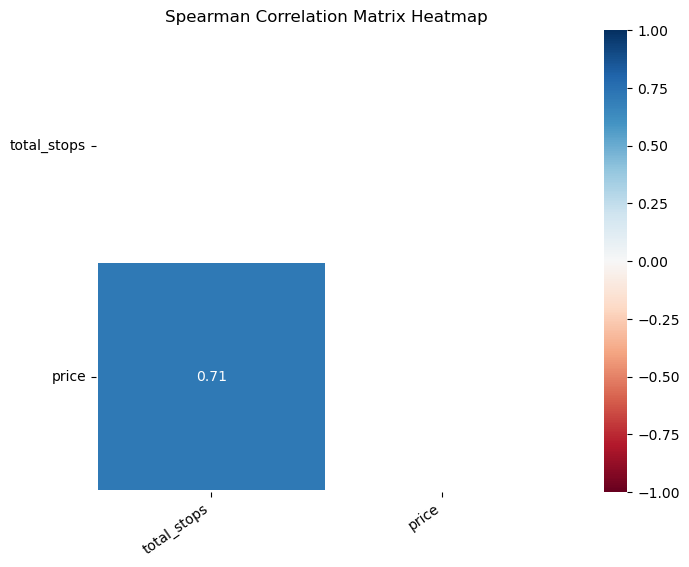

In [206]:
eda_helper_functions.correlation_heatmap(train[["total_stops", "price"]])